### Pipeline

The entire pipeline for comparing and see the correlation between the UST-HRV and the Standard one.

This process consist of several steps:
- Data Extraction 
- rPPG Validation (MAE /RMSE) for each Scenario with bland-altman aggrement 
- Making a section for each scenario (30 sec, 1min and standard one 3 min) for UBFC-Phys, (30 sec and 1 min) for Physio Itera
- Plot the correlation and check the limit within bland-altman
- Done.

## Data Extraction

This will structure the folder so it can be easier to access, all rPPG methods already be in the .npy files for easier acccess.

In [4]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy
import os
import neurokit2 as nk
from prettytable import PrettyTable

In [5]:
def preprocess_ppg(signal, fs = 35):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    # # Moving Average Smoothing
    # window = int(fs * 0.15)  # 150ms window
    # smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    # b, a = scipy.signal.butter(2, [0.5, 2.5], btype='band', fs=fs)
    # filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # # Additional lowpass to remove high-frequency noise
    # b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    # filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # # Moving average smoothing
    # window = int(fs * 0.15)  # 150ms window
    # filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # # Normalize the signal
    # normalized_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))


    # return normalized_signal

    b, a = scipy.signal.butter(3, [0.5, 2.5], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, signal)

    return filtered



## UBFC-Phys Scenario-1 (Task 1)

Plot the data and see the data variation between models within tables views and compare with the GT

In [6]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T1"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        
        # Flatten the value for the GT
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)

        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_hr:.2f}", f"{lgi_hr:.2f}",
            f"{omit_hr:.2f}", f"{green_hr:.2f}", f"{chrom_hr:.2f}"
        ])

## Print the table
print(table)


+---------+----------+-------+--------+--------+-------+--------+
| Subject | GT (BPM) |  POS  |  LGI   |  OMIT  | GREEN | CHROM  |
+---------+----------+-------+--------+--------+-------+--------+
|   s41   |  96.59   | 91.05 | 92.57  | 92.58  | 87.77 | 93.24  |
|   s42   |  69.83   | 73.20 | 71.00  | 71.03  | 66.73 | 72.27  |
|   s43   |  95.11   | 89.17 | 90.25  | 90.24  | 79.92 | 91.34  |
|   s44   |  63.08   | 62.72 | 62.97  | 62.96  | 62.43 | 68.40  |
|   s45   |  76.90   | 75.99 | 73.80  | 73.75  | 69.16 | 74.44  |
|   s46   |  74.65   | 74.65 | 74.41  | 74.41  | 74.40 | 74.85  |
|   s47   |  77.22   | 75.43 | 76.85  | 76.52  | 72.26 | 77.25  |
|   s48   |  58.06   | 70.75 | 69.96  | 69.95  | 65.44 | 70.12  |
|   s49   |  101.14  | 95.11 | 100.15 | 100.12 | 98.31 | 101.02 |
|   s50   |  103.28  | 87.75 | 93.39  | 93.37  | 82.05 | 91.40  |
|   s51   |  62.66   | 62.59 | 62.25  | 62.25  | 62.05 | 62.76  |
|   s52   |  78.42   | 84.72 | 86.28  | 86.29  | 78.25 | 84.33  |
|   s53   

Compute the MAE / RMSE evaluation

In [7]:
## Compute the mae / rmse for each method
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T1"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)

        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

        # Compute the mae / rmse for each method
        pos_mae = np.mean(np.abs(pos_hr - gt_hr))
        lgi_mae = np.mean(np.abs(lgi_hr - gt_hr))
        omit_mae = np.mean(np.abs(omit_hr - gt_hr))
        green_mae = np.mean(np.abs(green_hr - gt_hr))
        chrom_mae = np.mean(np.abs(chrom_hr - gt_hr))
        pos_rmse = np.sqrt(np.mean((pos_hr - gt_hr) ** 2))
        lgi_rmse = np.sqrt(np.mean((lgi_hr - gt_hr) ** 2))
        omit_rmse = np.sqrt(np.mean((omit_hr - gt_hr) ** 2))
        green_rmse = np.sqrt(np.mean((green_hr - gt_hr) ** 2))
        chrom_rmse = np.sqrt(np.mean((chrom_hr - gt_hr) ** 2))


        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_mae:.2f} / {pos_rmse:.2f}", f"{lgi_mae:.2f} / {lgi_rmse:.2f}",
            f"{omit_mae:.2f} / {omit_rmse:.2f}", f"{green_mae:.2f} / {green_rmse:.2f}", f"{chrom_mae:.2f} / {chrom_rmse:.2f}"
        ])

## Print the table
print(table)


+---------+----------+---------------+---------------+---------------+---------------+---------------+
| Subject | GT (BPM) |      POS      |      LGI      |      OMIT     |     GREEN     |     CHROM     |
+---------+----------+---------------+---------------+---------------+---------------+---------------+
|   s41   |  96.59   |  5.54 / 5.54  |  4.03 / 4.03  |  4.02 / 4.02  |  8.83 / 8.83  |  3.36 / 3.36  |
|   s42   |  69.83   |  3.38 / 3.38  |  1.17 / 1.17  |  1.20 / 1.20  |  3.10 / 3.10  |  2.44 / 2.44  |
|   s43   |  95.11   |  5.94 / 5.94  |  4.86 / 4.86  |  4.87 / 4.87  | 15.19 / 15.19 |  3.77 / 3.77  |
|   s44   |  63.08   |  0.36 / 0.36  |  0.11 / 0.11  |  0.11 / 0.11  |  0.65 / 0.65  |  5.32 / 5.32  |
|   s45   |  76.90   |  0.92 / 0.92  |  3.10 / 3.10  |  3.15 / 3.15  |  7.74 / 7.74  |  2.46 / 2.46  |
|   s46   |  74.65   |  0.00 / 0.00  |  0.24 / 0.24  |  0.24 / 0.24  |  0.25 / 0.25  |  0.20 / 0.20  |
|   s47   |  77.22   |  1.78 / 1.78  |  0.37 / 0.37  |  0.70 / 0.70  |  4

Compute the bland-altman

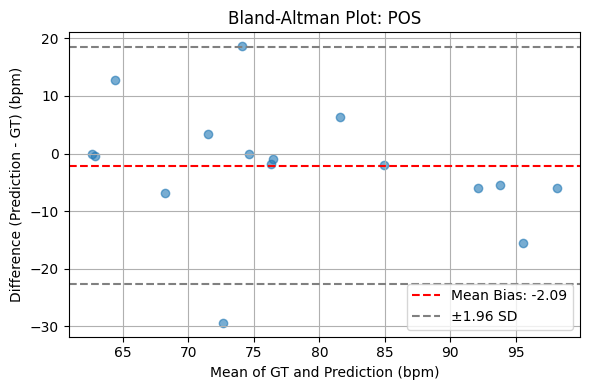

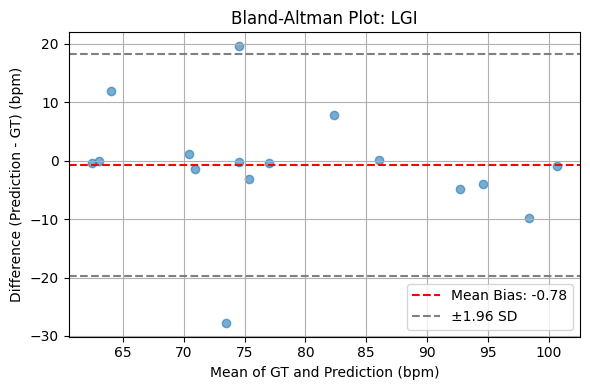

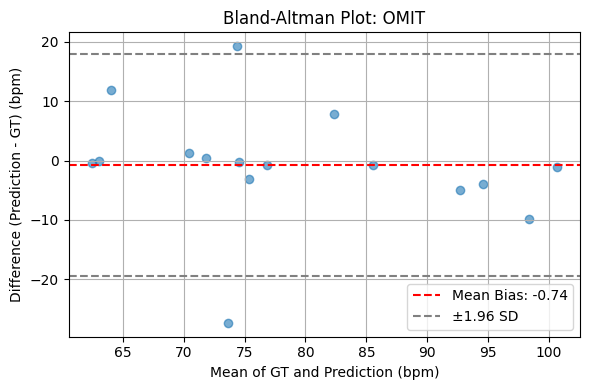

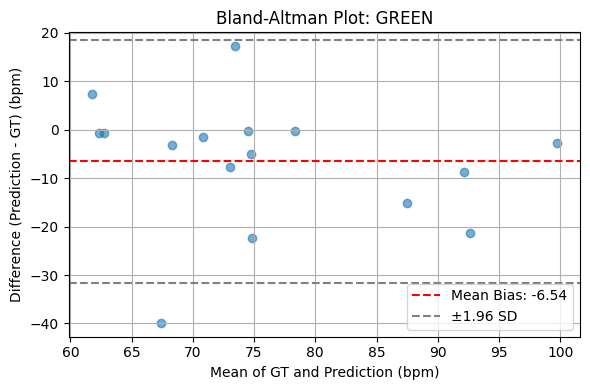

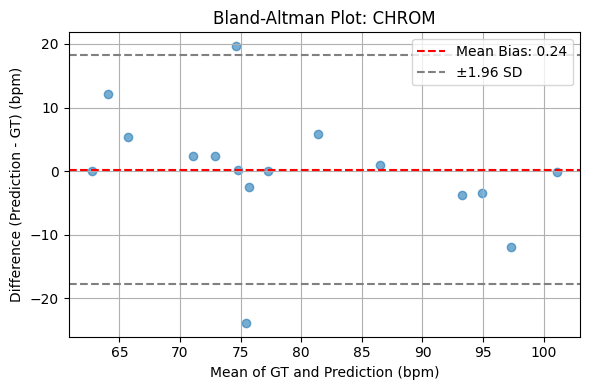

In [8]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T1"]

# Store HRs
hr_data = {
    "POS": [],
    "LGI": [],
    "OMIT": [],
    "GREEN": [],
    "CHROM": [],
    "GT": []
}

# Process and collect HR data
for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
        continue
    
    for task in tasks:
        try:
            pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
            lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
            omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
            green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
            chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))
            GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
            GT = GT.flatten()


            ## Preprocess the signal
            pos = preprocess_ppg(pos, fs=35)
            lgi = preprocess_ppg(lgi, fs=35)
            omit = preprocess_ppg(omit, fs=35)
            green = preprocess_ppg(green, fs=35)
            chrom = preprocess_ppg(chrom, fs=35)
            GT = preprocess_ppg(GT, fs=64)

            pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
            lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
            omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
            green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
            chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
            gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

            hr_data["POS"].append(pos_hr)
            hr_data["LGI"].append(lgi_hr)
            hr_data["OMIT"].append(omit_hr)
            hr_data["GREEN"].append(green_hr)
            hr_data["CHROM"].append(chrom_hr)
            hr_data["GT"].append(gt_hr)

        except Exception as e:
            print(f"Error processing {subject} - {task}: {e}")

# Convert to DataFrame
df_hr = pd.DataFrame(hr_data)

# Plot Bland-Altman
def plot_bland_altman(method_name, predicted, gt):
    mean_hr = (np.array(predicted) + np.array(gt)) / 2
    diff_hr = np.array(predicted) - np.array(gt)
    mean_diff = np.mean(diff_hr)
    std_diff = np.std(diff_hr)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean_hr, diff_hr, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f}")
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label="±1.96 SD")
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f"Bland-Altman Plot: {method_name}")
    plt.xlabel("Mean of GT and Prediction (bpm)")
    plt.ylabel("Difference (Prediction - GT) (bpm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each method
for method in ["POS", "LGI", "OMIT", "GREEN", "CHROM"]:
    plot_bland_altman(method, df_hr[method], df_hr["GT"])



## UBFC-Phys Scenario-2 (Task 2)

Plot the data and see the data variation between models within tables views and compare with the GT

In [9]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T2"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)

        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()


        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_hr:.2f}", f"{lgi_hr:.2f}",
            f"{omit_hr:.2f}", f"{green_hr:.2f}", f"{chrom_hr:.2f}"
        ])

## Print the table
print(table)


+---------+----------+-------+-------+-------+-------+-------+
| Subject | GT (BPM) |  POS  |  LGI  |  OMIT | GREEN | CHROM |
+---------+----------+-------+-------+-------+-------+-------+
|   s41   |  75.99   | 82.74 | 89.06 | 89.46 | 70.87 | 85.19 |
|   s42   |  76.87   | 74.71 | 64.26 | 64.79 | 66.40 | 68.78 |
|   s43   |  87.83   | 79.80 | 77.77 | 79.00 | 63.32 | 69.48 |
|   s44   |  68.19   | 69.84 | 68.94 | 68.17 | 65.45 | 66.20 |
|   s45   |  80.07   | 72.50 | 66.80 | 67.45 | 58.93 | 67.90 |
|   s46   |  76.98   | 72.85 | 74.57 | 75.27 | 63.30 | 73.11 |
|   s47   |  70.59   | 90.63 | 93.66 | 93.32 | 71.46 | 97.41 |
|   s48   |  73.06   | 74.78 | 73.36 | 73.79 | 61.80 | 70.52 |
|   s49   |  80.29   | 67.02 | 64.15 | 64.15 | 58.67 | 66.10 |
|   s50   |  84.03   | 82.91 | 84.97 | 85.24 | 72.13 | 84.76 |
|   s51   |  68.64   | 72.81 | 64.50 | 65.33 | 47.47 | 66.86 |
|   s52   |  79.86   | 79.16 | 81.44 | 80.81 | 64.10 | 80.11 |
|   s53   |  66.88   | 77.25 | 77.07 | 77.05 | 59.43 | 

compute the MAE / RMSE

In [10]:
## Compute the mae / rmse for each method
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T2"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)

        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

        # Compute the mae / rmse for each method
        pos_mae = np.mean(np.abs(pos_hr - gt_hr))
        lgi_mae = np.mean(np.abs(lgi_hr - gt_hr))
        omit_mae = np.mean(np.abs(omit_hr - gt_hr))
        green_mae = np.mean(np.abs(green_hr - gt_hr))
        chrom_mae = np.mean(np.abs(chrom_hr - gt_hr))
        pos_rmse = np.sqrt(np.mean((pos_hr - gt_hr) ** 2))
        lgi_rmse = np.sqrt(np.mean((lgi_hr - gt_hr) ** 2))
        omit_rmse = np.sqrt(np.mean((omit_hr - gt_hr) ** 2))
        green_rmse = np.sqrt(np.mean((green_hr - gt_hr) ** 2))
        chrom_rmse = np.sqrt(np.mean((chrom_hr - gt_hr) ** 2))


        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_mae:.2f} / {pos_rmse:.2f}", f"{lgi_mae:.2f} / {lgi_rmse:.2f}",
            f"{omit_mae:.2f} / {omit_rmse:.2f}", f"{green_mae:.2f} / {green_rmse:.2f}", f"{chrom_mae:.2f} / {chrom_rmse:.2f}"
        ])

## Print the table
print(table)
 

+---------+----------+---------------+---------------+---------------+---------------+---------------+
| Subject | GT (BPM) |      POS      |      LGI      |      OMIT     |     GREEN     |     CHROM     |
+---------+----------+---------------+---------------+---------------+---------------+---------------+
|   s41   |  75.99   |  6.76 / 6.76  | 13.08 / 13.08 | 13.48 / 13.48 |  5.12 / 5.12  |  9.21 / 9.21  |
|   s42   |  76.87   |  2.16 / 2.16  | 12.61 / 12.61 | 12.08 / 12.08 | 10.47 / 10.47 |  8.09 / 8.09  |
|   s43   |  87.83   |  8.03 / 8.03  | 10.07 / 10.07 |  8.83 / 8.83  | 24.51 / 24.51 | 18.36 / 18.36 |
|   s44   |  68.19   |  1.65 / 1.65  |  0.75 / 0.75  |  0.02 / 0.02  |  2.74 / 2.74  |  1.99 / 1.99  |
|   s45   |  80.07   |  7.57 / 7.57  | 13.27 / 13.27 | 12.63 / 12.63 | 21.14 / 21.14 | 12.17 / 12.17 |
|   s46   |  76.98   |  4.13 / 4.13  |  2.40 / 2.40  |  1.70 / 1.70  | 13.68 / 13.68 |  3.87 / 3.87  |
|   s47   |  70.59   | 20.04 / 20.04 | 23.07 / 23.07 | 22.73 / 22.73 |  0

Plot the Bland-Altman

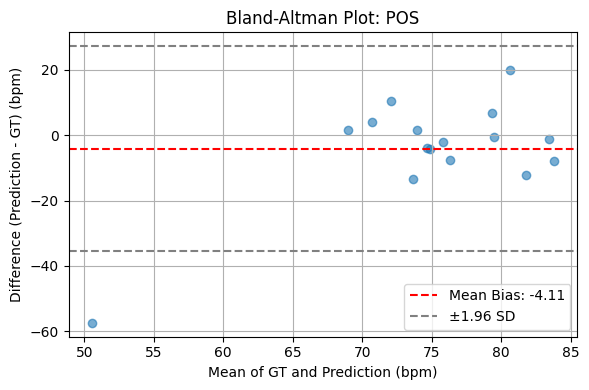

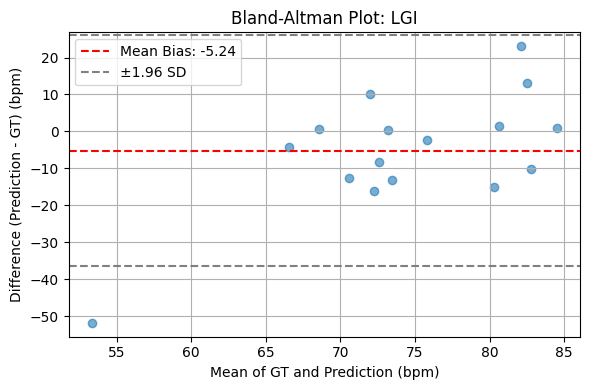

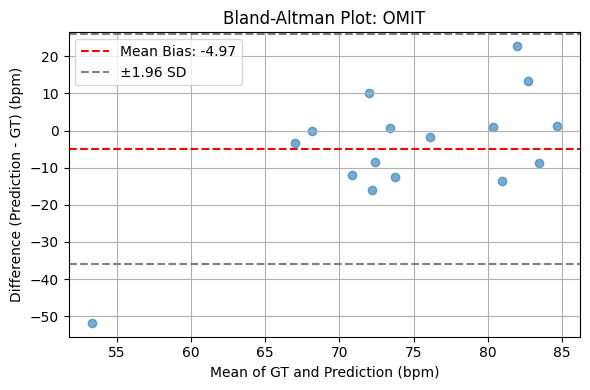

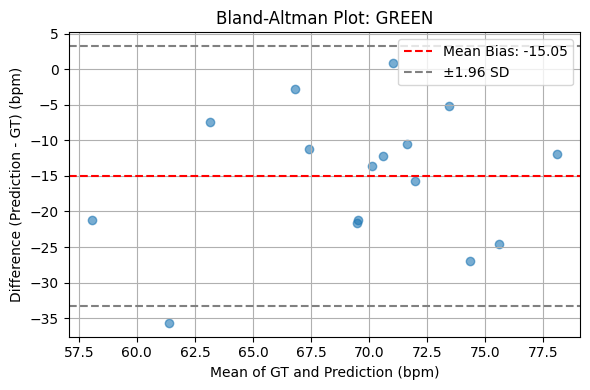

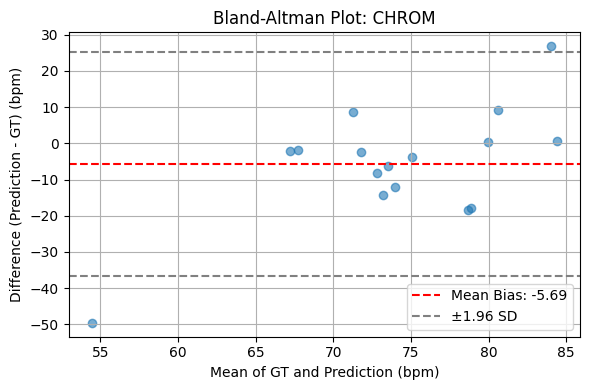

In [11]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T2"]

# Store HRs
hr_data = {
    "POS": [],
    "LGI": [],
    "OMIT": [],
    "GREEN": [],
    "CHROM": [],
    "GT": []
}

# Process and collect HR data
for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
        continue
    
    for task in tasks:
        try:
            pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
            lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
            omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
            green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
            chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))
            GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
            GT = GT.flatten()

            ## Preprocess the signal
            pos = preprocess_ppg(pos, fs=35)
            lgi = preprocess_ppg(lgi, fs=35)
            omit = preprocess_ppg(omit, fs=35)
            green = preprocess_ppg(green, fs=35)
            chrom = preprocess_ppg(chrom, fs=35)
            GT = preprocess_ppg(GT, fs=64)

            pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
            lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
            omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
            green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
            chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
            gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

            hr_data["POS"].append(pos_hr)
            hr_data["LGI"].append(lgi_hr)
            hr_data["OMIT"].append(omit_hr)
            hr_data["GREEN"].append(green_hr)
            hr_data["CHROM"].append(chrom_hr)
            hr_data["GT"].append(gt_hr)

        except Exception as e:
            print(f"Error processing {subject} - {task}: {e}")

# Convert to DataFrame
df_hr = pd.DataFrame(hr_data)

# Plot Bland-Altman
def plot_bland_altman(method_name, predicted, gt):
    mean_hr = (np.array(predicted) + np.array(gt)) / 2
    diff_hr = np.array(predicted) - np.array(gt)
    mean_diff = np.mean(diff_hr)
    std_diff = np.std(diff_hr)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean_hr, diff_hr, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f}")
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label="±1.96 SD")
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f"Bland-Altman Plot: {method_name}")
    plt.xlabel("Mean of GT and Prediction (bpm)")
    plt.ylabel("Difference (Prediction - GT) (bpm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each method
for method in ["POS", "LGI", "OMIT", "GREEN", "CHROM"]:
    plot_bland_altman(method, df_hr[method], df_hr["GT"])



## UBFC-Phys Scenario-3 (Task 3)

Plot the data and see the data variation between models within tables views and compare with the GT

In [12]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T3"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)


        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()
        


        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_hr:.2f}", f"{lgi_hr:.2f}",
            f"{omit_hr:.2f}", f"{green_hr:.2f}", f"{chrom_hr:.2f}"
        ])

## Print the table
print(table)


+---------+----------+-------+-------+-------+-------+-------+
| Subject | GT (BPM) |  POS  |  LGI  |  OMIT | GREEN | CHROM |
+---------+----------+-------+-------+-------+-------+-------+
|   s41   |  78.59   | 86.95 | 88.50 | 86.36 | 64.19 | 90.30 |
|   s42   |  79.78   | 79.39 | 64.62 | 65.74 | 66.38 | 67.18 |
|   s43   |  83.18   | 77.06 | 75.63 | 69.61 | 61.03 | 76.71 |
|   s44   |  65.81   | 68.39 | 68.56 | 68.71 | 57.63 | 68.05 |
|   s45   |  82.70   | 73.00 | 63.64 | 63.65 | 59.36 | 67.20 |
|   s46   |  88.35   | 78.47 | 80.00 | 80.28 | 72.43 | 83.44 |
|   s47   |  73.64   | 75.07 | 77.46 | 74.94 | 64.24 | 78.35 |
|   s48   |  67.01   | 67.30 | 71.78 | 71.11 | 63.77 | 69.74 |
|   s49   |  68.01   | 70.64 | 68.76 | 65.61 | 48.18 | 70.64 |
|   s50   |  101.89  | 87.59 | 91.45 | 91.41 | 66.25 | 91.36 |
|   s51   |  71.56   | 73.09 | 71.10 | 71.14 | 54.59 | 69.01 |
|   s52   |  74.24   | 77.21 | 77.41 | 78.15 | 67.34 | 76.51 |
|   s53   |  68.28   | 71.83 | 70.76 | 70.76 | 64.84 | 

plot the MAE / RMSE

In [13]:
## Compute the mae / rmse for each method
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T3"]

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
    
    for task in tasks:
        # Plot the path of the OMIT, POS, and LGI, CHROM and GREEN
        pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
        lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
        omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
        green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
        chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))

        # Open the GT file
        GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
        GT = GT.flatten()

        ## Preprocess the signal
        pos = preprocess_ppg(pos, fs=35)
        lgi = preprocess_ppg(lgi, fs=35)
        omit = preprocess_ppg(omit, fs=35)
        green = preprocess_ppg(green, fs=35)
        chrom = preprocess_ppg(chrom, fs=35)
        GT = preprocess_ppg(GT, fs=64)


        # Process all the signals
        pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
        lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
        omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
        green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
        chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()

        gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

        # Compute the mae / rmse for each method
        pos_mae = np.mean(np.abs(pos_hr - gt_hr))
        lgi_mae = np.mean(np.abs(lgi_hr - gt_hr))
        omit_mae = np.mean(np.abs(omit_hr - gt_hr))
        green_mae = np.mean(np.abs(green_hr - gt_hr))
        chrom_mae = np.mean(np.abs(chrom_hr - gt_hr))
        pos_rmse = np.sqrt(np.mean((pos_hr - gt_hr) ** 2))
        lgi_rmse = np.sqrt(np.mean((lgi_hr - gt_hr) ** 2))
        omit_rmse = np.sqrt(np.mean((omit_hr - gt_hr) ** 2))
        green_rmse = np.sqrt(np.mean((green_hr - gt_hr) ** 2))
        chrom_rmse = np.sqrt(np.mean((chrom_hr - gt_hr) ** 2))


        table.add_row([
            subject, f"{gt_hr:.2f}", f"{pos_mae:.2f} / {pos_rmse:.2f}", f"{lgi_mae:.2f} / {lgi_rmse:.2f}",
            f"{omit_mae:.2f} / {omit_rmse:.2f}", f"{green_mae:.2f} / {green_rmse:.2f}", f"{chrom_mae:.2f} / {chrom_rmse:.2f}"
        ])

## Print the table
print(table)
 

+---------+----------+---------------+---------------+---------------+---------------+---------------+
| Subject | GT (BPM) |      POS      |      LGI      |      OMIT     |     GREEN     |     CHROM     |
+---------+----------+---------------+---------------+---------------+---------------+---------------+
|   s41   |  78.59   |  8.36 / 8.36  |  9.91 / 9.91  |  7.77 / 7.77  | 14.39 / 14.39 | 11.71 / 11.71 |
|   s42   |  79.78   |  0.38 / 0.38  | 15.15 / 15.15 | 14.04 / 14.04 | 13.40 / 13.40 | 12.60 / 12.60 |
|   s43   |  83.18   |  6.12 / 6.12  |  7.55 / 7.55  | 13.58 / 13.58 | 22.16 / 22.16 |  6.47 / 6.47  |
|   s44   |  65.81   |  2.58 / 2.58  |  2.75 / 2.75  |  2.90 / 2.90  |  8.18 / 8.18  |  2.25 / 2.25  |
|   s45   |  82.70   |  9.70 / 9.70  | 19.07 / 19.07 | 19.06 / 19.06 | 23.34 / 23.34 | 15.51 / 15.51 |
|   s46   |  88.35   |  9.88 / 9.88  |  8.35 / 8.35  |  8.07 / 8.07  | 15.91 / 15.91 |  4.90 / 4.90  |
|   s47   |  73.64   |  1.42 / 1.42  |  3.81 / 3.81  |  1.30 / 1.30  |  9

Plot the bland-altman

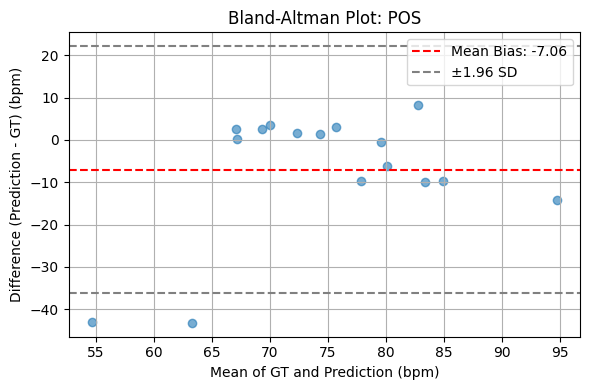

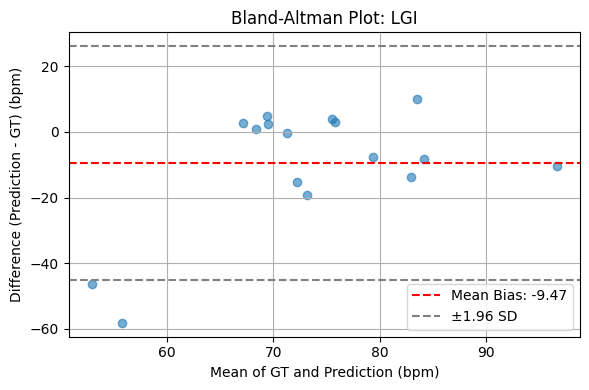

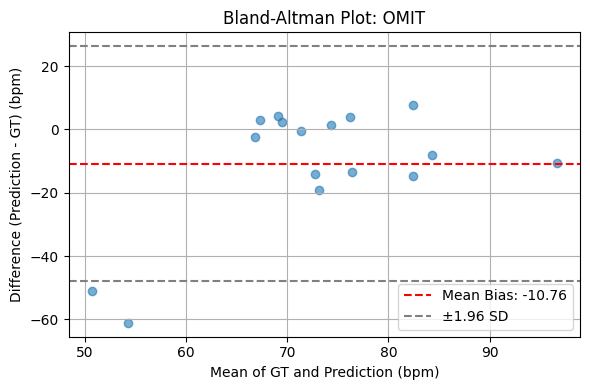

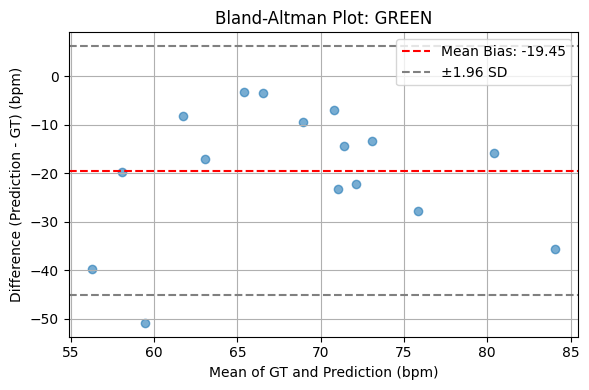

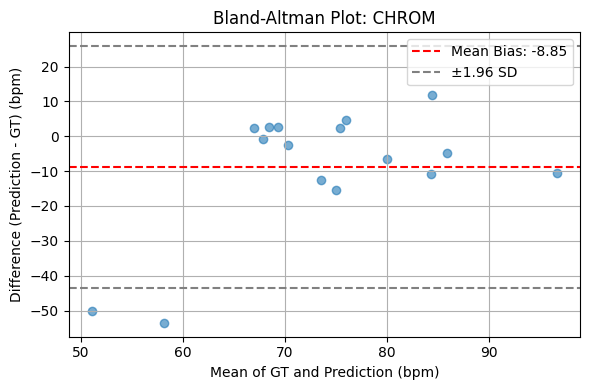

In [14]:
root_path = "UBFC-Phys"
subjects = ["s41", "s42", "s43", "s44","s45","s46","s47","s48","s49","s50","s51","s52", "s53","s54","s55","s56",]
tasks = ["T3"]

# Store HRs
hr_data = {
    "POS": [],
    "LGI": [],
    "OMIT": [],
    "GREEN": [],
    "CHROM": [],
    "GT": []
}

# Process and collect HR data
for subject in subjects:
    if not os.path.exists(f"{root_path}/{subject}"):
        print(f"Subject {subject} not found, skipping")
        continue
    
    for task in tasks:
        try:
            pos = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_POS_rppg.npy"))
            lgi = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_LGI_rppg.npy"))
            omit = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_OMIT_rppg.npy"))
            green = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_GREEN_rppg.npy"))
            chrom = np.load(os.path.join(root_path, subject, f"Landmark_{subject}_{task}_CHROM_rppg.npy"))
            GT = pd.read_csv(os.path.join(root_path, subject, f"bvp_{subject}_{task}.csv")).values
            GT = GT.flatten()

            ## Preprocess the signal
            pos = preprocess_ppg(pos, fs=35)
            lgi = preprocess_ppg(lgi, fs=35)
            omit = preprocess_ppg(omit, fs=35)
            green = preprocess_ppg(green, fs=35)
            chrom = preprocess_ppg(chrom, fs=35)
            GT = preprocess_ppg(GT, fs=64)

            pos_hr = nk.ppg_process(pos, sampling_rate=35)[0]["PPG_Rate"].mean()
            lgi_hr = nk.ppg_process(lgi, sampling_rate=35)[0]["PPG_Rate"].mean()
            omit_hr = nk.ppg_process(omit, sampling_rate=35)[0]["PPG_Rate"].mean()
            green_hr = nk.ppg_process(green, sampling_rate=35)[0]["PPG_Rate"].mean()
            chrom_hr = nk.ppg_process(chrom, sampling_rate=35)[0]["PPG_Rate"].mean()
            gt_hr = nk.ppg_process(GT, sampling_rate=64)[0]["PPG_Rate"].mean()

            hr_data["POS"].append(pos_hr)
            hr_data["LGI"].append(lgi_hr)
            hr_data["OMIT"].append(omit_hr)
            hr_data["GREEN"].append(green_hr)
            hr_data["CHROM"].append(chrom_hr)
            hr_data["GT"].append(gt_hr)

        except Exception as e:
            print(f"Error processing {subject} - {task}: {e}")

# Convert to DataFrame
df_hr = pd.DataFrame(hr_data)

# Plot Bland-Altman
def plot_bland_altman(method_name, predicted, gt):
    mean_hr = (np.array(predicted) + np.array(gt)) / 2
    diff_hr = np.array(predicted) - np.array(gt)
    mean_diff = np.mean(diff_hr)
    std_diff = np.std(diff_hr)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean_hr, diff_hr, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f}")
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label="±1.96 SD")
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f"Bland-Altman Plot: {method_name}")
    plt.xlabel("Mean of GT and Prediction (bpm)")
    plt.ylabel("Difference (Prediction - GT) (bpm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each method
for method in ["POS", "LGI", "OMIT", "GREEN", "CHROM"]:
    plot_bland_altman(method, df_hr[method], df_hr["GT"])



### Notes

Whut the Task 2 and 3 have a lot of outlier for the MAE / RMSE lmao

## Physio Itera Scenario-2 (Task 2)

Plot the data and see the data variation between models within tables views and compare with the GT

In [17]:
## mapping the folders
base_path=f"PhysioItera"

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

## Mapping the folders
subjects=os.listdir(base_path)

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("2"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"

    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Preprocess the signal
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    # Downsample GT from 64 Hz to 35 Hz
    # original_length = len(GT)
    # target_length = int(original_length * (30/200))  # Calculate new length based on ratio of sampling rates
    # GT_downsampled = scipy.signal.resample(GT, target_length)

    # Plot length of the pos signal
    # print(f"Length of the pos signal: {subject}: {len(pos)}")
    # print(f"Length of the lgi signal: {subject}: {len(lgi)}")
    # print(f"Length of the omit signal: {subject}: {len(omit)}")
    # print(f"Length of the green signal: {subject}: {len(green)}")
    # print(f"Length of the chrom signal: {subject}: {len(chrom)}")
    # print("==================================")

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()  # Use 35 Hz for downsampled GT

    table.add_row([
        subject, f"{gt_hr:.2f}", f"{pos_hr:.2f}", f"{lgi_hr:.2f}",
        f"{omit_hr:.2f}", f"{green_hr:.2f}", f"{chrom_hr:.2f}"
    ])

## Print the table
print(table)


+---------+----------+-------+-------+-------+-------+-------+
| Subject | GT (BPM) |  POS  |  LGI  |  OMIT | GREEN | CHROM |
+---------+----------+-------+-------+-------+-------+-------+
|  ades2  |  88.61   | 82.23 | 78.31 | 78.33 | 78.64 | 81.13 |
|  adin2  |  80.94   | 81.57 | 80.39 | 79.76 | 74.00 | 82.75 |
|  agus2  |  116.34  | 75.53 | 78.22 | 78.22 | 75.75 | 79.84 |
|  aice2  |  133.94  | 92.88 | 89.60 | 89.60 | 84.36 | 83.16 |
|  alana2 |  94.99   | 83.92 | 83.00 | 83.00 | 77.13 | 84.05 |
|  alex2  |  82.74   | 73.56 | 71.59 | 72.71 | 76.95 | 74.58 |
|   ali2  |  99.22   | 78.38 | 82.26 | 82.26 | 84.97 | 83.77 |
| anggur2 |  96.57   | 82.86 | 82.69 | 82.69 | 79.10 | 87.88 |
|   ara2  |  89.64   | 81.39 | 79.41 | 78.31 | 79.23 | 83.37 |
| arnold2 |  90.89   | 79.33 | 75.40 | 75.40 | 74.55 | 79.14 |
|  bunny2 |  85.77   | 75.55 | 73.88 | 75.18 | 75.97 | 84.11 |
|  cici2  |  105.57  | 81.47 | 77.35 | 77.35 | 76.88 | 83.75 |
|  citra2 |  95.53   | 77.78 | 80.25 | 79.00 | 79.23 | 

Plot for the metric evaluation MAE / RMSE

In [18]:
# Compute the mae / rmse for each method
# mapping the folders
base_path=f"PhysioItera"

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("2"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"

    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Preprocess the signal
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()


    # Compute the mae / rmse for each method
    pos_mae = np.mean(np.abs(pos_hr - gt_hr))
    lgi_mae = np.mean(np.abs(lgi_hr - gt_hr))
    omit_mae = np.mean(np.abs(omit_hr - gt_hr))
    green_mae = np.mean(np.abs(green_hr - gt_hr))
    chrom_mae = np.mean(np.abs(chrom_hr - gt_hr))
    pos_rmse = np.sqrt(np.mean((pos_hr - gt_hr) ** 2))
    lgi_rmse = np.sqrt(np.mean((lgi_hr - gt_hr) ** 2))
    omit_rmse = np.sqrt(np.mean((omit_hr - gt_hr) ** 2))
    green_rmse = np.sqrt(np.mean((green_hr - gt_hr) ** 2))
    chrom_rmse = np.sqrt(np.mean((chrom_hr - gt_hr) ** 2))


    table.add_row([
        subject, f"{gt_hr:.2f}", f"{pos_mae:.2f} / {pos_rmse:.2f}", f"{lgi_mae:.2f} / {lgi_rmse:.2f}",
        f"{omit_mae:.2f} / {omit_rmse:.2f}", f"{green_mae:.2f} / {green_rmse:.2f}", f"{chrom_mae:.2f} / {chrom_rmse:.2f}"
    ])

## Print the table
print(table)
 

+---------+----------+---------------+---------------+---------------+---------------+---------------+
| Subject | GT (BPM) |      POS      |      LGI      |      OMIT     |     GREEN     |     CHROM     |
+---------+----------+---------------+---------------+---------------+---------------+---------------+
|  ades2  |  88.61   |  6.38 / 6.38  | 10.30 / 10.30 | 10.29 / 10.29 |  9.98 / 9.98  |  7.48 / 7.48  |
|  adin2  |  80.94   |  0.63 / 0.63  |  0.55 / 0.55  |  1.18 / 1.18  |  6.95 / 6.95  |  1.81 / 1.81  |
|  agus2  |  116.34  | 40.81 / 40.81 | 38.12 / 38.12 | 38.12 / 38.12 | 40.59 / 40.59 | 36.50 / 36.50 |
|  aice2  |  133.94  | 41.06 / 41.06 | 44.34 / 44.34 | 44.34 / 44.34 | 49.58 / 49.58 | 50.78 / 50.78 |
|  alana2 |  94.99   | 11.07 / 11.07 | 11.99 / 11.99 | 11.98 / 11.98 | 17.86 / 17.86 | 10.93 / 10.93 |
|  alex2  |  82.74   |  9.18 / 9.18  | 11.15 / 11.15 | 10.03 / 10.03 |  5.78 / 5.78  |  8.16 / 8.16  |
|   ali2  |  99.22   | 20.83 / 20.83 | 16.95 / 16.95 | 16.95 / 16.95 | 14

plot the bland-altman plot

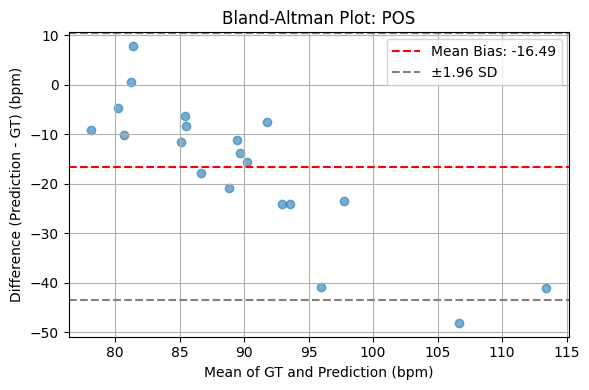

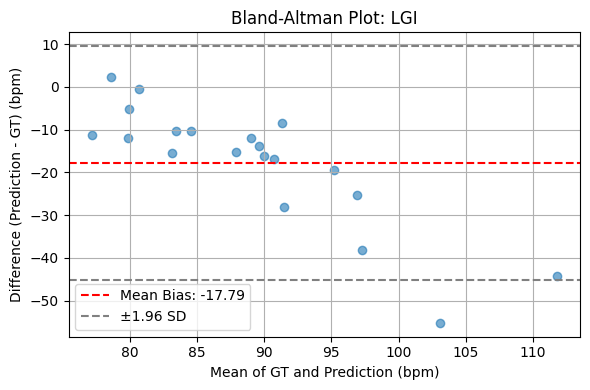

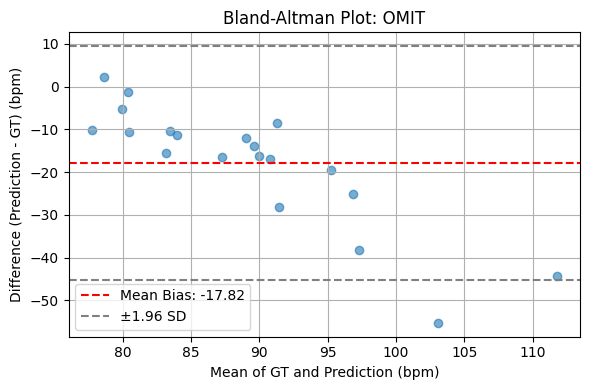

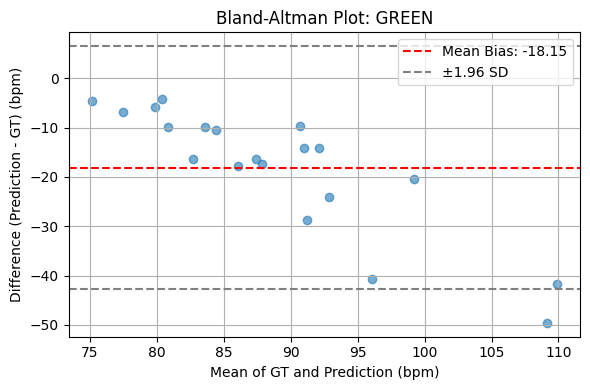

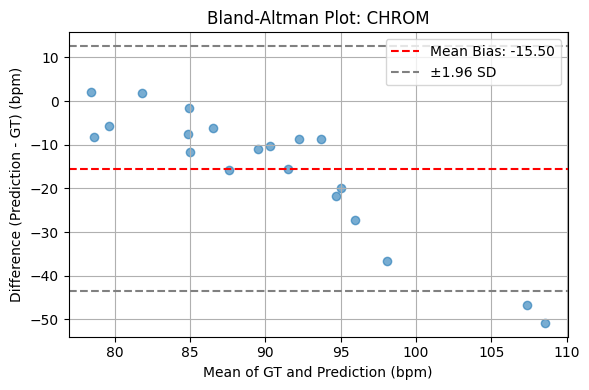

In [19]:
base_path=f"PhysioItera"

# Store HRs
hr_data = {
    "POS": [],
    "LGI": [],
    "OMIT": [],
    "GREEN": [],
    "CHROM": [],
    "GT": []
}

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("2"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"
    
    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Preprocess the signal
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()

    hr_data["POS"].append(pos_hr)
    hr_data["LGI"].append(lgi_hr)
    hr_data["OMIT"].append(omit_hr)
    hr_data["GREEN"].append(green_hr)
    hr_data["CHROM"].append(chrom_hr)
    hr_data["GT"].append(gt_hr)

# Convert to DataFrame
df_hr = pd.DataFrame(hr_data)

# Plot Bland-Altman
def plot_bland_altman(method_name, predicted, gt):
    mean_hr = (np.array(predicted) + np.array(gt)) / 2
    diff_hr = np.array(predicted) - np.array(gt)
    mean_diff = np.mean(diff_hr)
    std_diff = np.std(diff_hr)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean_hr, diff_hr, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f}")
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label="±1.96 SD")
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f"Bland-Altman Plot: {method_name}")
    plt.xlabel("Mean of GT and Prediction (bpm)")
    plt.ylabel("Difference (Prediction - GT) (bpm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each method
for method in ["POS", "LGI", "OMIT", "GREEN", "CHROM"]:
    plot_bland_altman(method, df_hr[method], df_hr["GT"])



## Physio Itera Scenario-6 (Task 6)

Plot the data and see the data variation between models within tables views and compare with the GT

In [23]:
## mapping the folders
base_path=f"PhysioItera"

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

## Mapping the folders
subjects=os.listdir(base_path)

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("6"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"

    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Check validation length less than 1500 frames, so skip
    if len(pos) < 1500 or len(lgi) < 1500 or len(omit) < 1500 or len(green) < 1500 or len(chrom) < 1500:
        print(f"Subject {subject} has less than 1500 frames, skipping")
        continue

    ## Preprocess the signal
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()

    table.add_row([
        subject, f"{gt_hr:.2f}", f"{pos_hr:.2f}", f"{lgi_hr:.2f}",
        f"{omit_hr:.2f}", f"{green_hr:.2f}", f"{chrom_hr:.2f}"
    ])

## Print the table
print(table)


Subject agus6 has less than 1500 frames, skipping
Subject bunny6 has less than 1500 frames, skipping
+---------+----------+-------+-------+-------+-------+-------+
| Subject | GT (BPM) |  POS  |  LGI  |  OMIT | GREEN | CHROM |
+---------+----------+-------+-------+-------+-------+-------+
|  ades6  |  83.57   | 76.82 | 77.79 | 77.79 | 77.36 | 82.17 |
|  adin6  |  82.12   | 80.33 | 78.22 | 78.22 | 73.28 | 78.72 |
|  aice6  |  83.12   | 75.32 | 79.52 | 79.52 | 82.27 | 78.14 |
|  alana6 |  92.79   | 84.71 | 82.28 | 82.20 | 87.90 | 83.36 |
|  alex6  |  84.78   | 81.69 | 80.04 | 80.04 | 78.30 | 80.39 |
|   ali6  |  97.97   | 85.39 | 84.06 | 84.06 | 82.36 | 78.68 |
| anggur6 |  97.85   | 85.53 | 86.03 | 86.04 | 78.43 | 83.72 |
|   ara6  |  80.38   | 80.76 | 74.11 | 74.11 | 79.44 | 79.76 |
| arnold6 |  89.82   | 70.65 | 77.35 | 77.35 | 80.44 | 76.56 |
|  cici6  |  97.58   | 75.77 | 70.14 | 70.14 | 80.19 | 88.28 |
|  citra6 |  92.62   | 76.00 | 74.08 | 74.08 | 72.85 | 82.32 |
|  dadu6  |  109.

Plot for the metric evaluation MAE / RMSE

In [25]:
# Compute the mae / rmse for each method
# mapping the folders
base_path=f"PhysioItera"

table = PrettyTable()
table.field_names = ["Subject", "GT (BPM)", "POS", "LGI", "OMIT", "GREEN", "CHROM"]

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("6"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"

    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Check validation length less than 1500 frames, so skip
    if len(pos) < 1500 or len(lgi) < 1500 or len(omit) < 1500 or len(green) < 1500 or len(chrom) < 1500:
        print(f"Subject {subject} has less than 1500 frames, skipping")
        continue

    ## Preprocess the signal
    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()


    # Compute the mae / rmse for each method
    pos_mae = np.mean(np.abs(pos_hr - gt_hr))
    lgi_mae = np.mean(np.abs(lgi_hr - gt_hr))
    omit_mae = np.mean(np.abs(omit_hr - gt_hr))
    green_mae = np.mean(np.abs(green_hr - gt_hr))
    chrom_mae = np.mean(np.abs(chrom_hr - gt_hr))
    pos_rmse = np.sqrt(np.mean((pos_hr - gt_hr) ** 2))
    lgi_rmse = np.sqrt(np.mean((lgi_hr - gt_hr) ** 2))
    omit_rmse = np.sqrt(np.mean((omit_hr - gt_hr) ** 2))
    green_rmse = np.sqrt(np.mean((green_hr - gt_hr) ** 2))
    chrom_rmse = np.sqrt(np.mean((chrom_hr - gt_hr) ** 2))


    table.add_row([
        subject, f"{gt_hr:.2f}", f"{pos_mae:.2f} / {pos_rmse:.2f}", f"{lgi_mae:.2f} / {lgi_rmse:.2f}",
        f"{omit_mae:.2f} / {omit_rmse:.2f}", f"{green_mae:.2f} / {green_rmse:.2f}", f"{chrom_mae:.2f} / {chrom_rmse:.2f}"
    ])

## Print the table
print(table)
 

Subject agus6 has less than 1500 frames, skipping
Subject bunny6 has less than 1500 frames, skipping
+---------+----------+---------------+---------------+---------------+---------------+---------------+
| Subject | GT (BPM) |      POS      |      LGI      |      OMIT     |     GREEN     |     CHROM     |
+---------+----------+---------------+---------------+---------------+---------------+---------------+
|  ades6  |  83.57   |  6.75 / 6.75  |  5.78 / 5.78  |  5.78 / 5.78  |  6.21 / 6.21  |  1.40 / 1.40  |
|  adin6  |  82.12   |  1.78 / 1.78  |  3.89 / 3.89  |  3.89 / 3.89  |  8.84 / 8.84  |  3.39 / 3.39  |
|  aice6  |  83.12   |  7.81 / 7.81  |  3.60 / 3.60  |  3.60 / 3.60  |  0.86 / 0.86  |  4.99 / 4.99  |
|  alana6 |  92.79   |  8.07 / 8.07  | 10.51 / 10.51 | 10.59 / 10.59 |  4.89 / 4.89  |  9.43 / 9.43  |
|  alex6  |  84.78   |  3.10 / 3.10  |  4.74 / 4.74  |  4.74 / 4.74  |  6.49 / 6.49  |  4.39 / 4.39  |
|   ali6  |  97.97   | 12.58 / 12.58 | 13.91 / 13.91 | 13.91 / 13.91 | 15.6

Plot the bland-altman

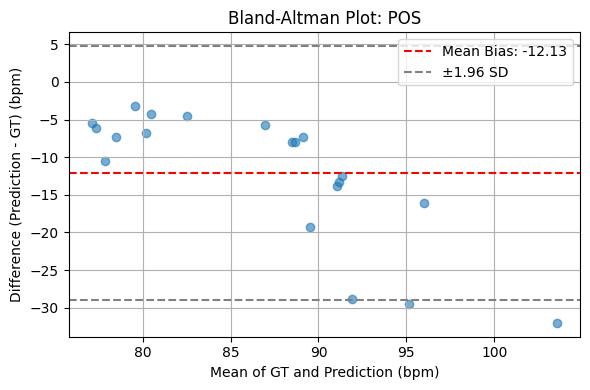

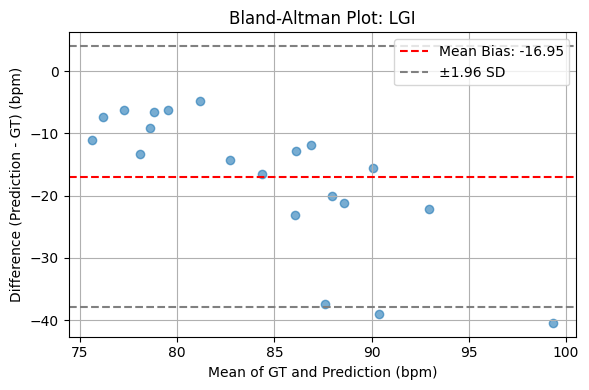

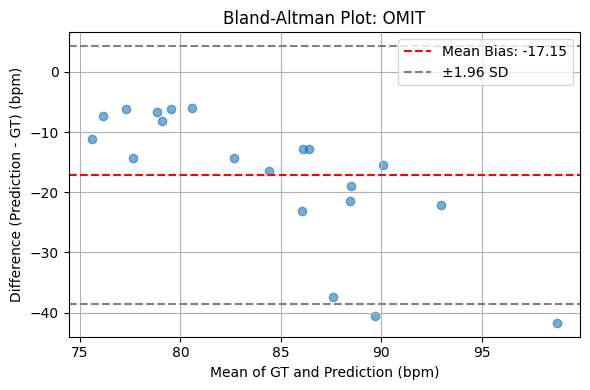

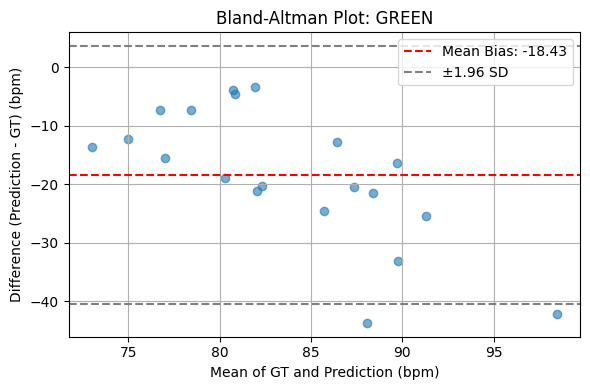

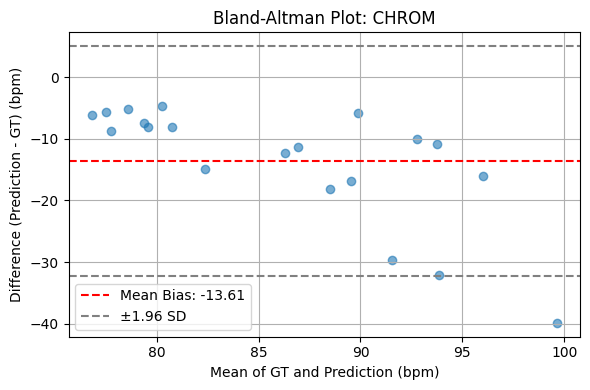

In [ ]:
base_path=f"PhysioItera"

# Store HRs
hr_data = {
    "POS": [],
    "LGI": [],
    "OMIT": [],
    "GREEN": [],
    "CHROM": [],
    "GT": []
}

## Loop the folders /rgb and /vernier
for subject in subjects:

    ## Make sure the folder ends in "2" for this subject
    if not subject.endswith("6"):
        # print(f"Subject {subject} not found, skipping")
        continue

    working_folder = base_path + f"/{subject}"
    
    pos = np.load(os.path.join(working_folder, f"Landmark-{subject}-POS-rppg.npy"))
    lgi = np.load(os.path.join(working_folder, f"Landmark-{subject}-LGI-rppg.npy"))
    omit = np.load(os.path.join(working_folder, f"Landmark-{subject}-OMIT-rppg.npy"))
    green = np.load(os.path.join(working_folder, f"Landmark-{subject}-GREEN-rppg.npy"))
    chrom = np.load(os.path.join(working_folder, f"Landmark-{subject}-CHROM-rppg.npy"))
    gt_path = os.path.join(working_folder, f"vernier/{subject}_vernier_ecg.csv")
    GT = pd.read_csv(gt_path, usecols=[1], header=None).values
    GT = GT.flatten()

    ## Check validation length less than 1500 frames, so skip
    if len(pos) < 1500 or len(lgi) < 1500 or len(omit) < 1500 or len(green) < 1500 or len(chrom) < 1500:
        print(f"Subject {subject} has less than 1500 frames, skipping")
        continue

    pos = preprocess_ppg(pos, fs=30)
    lgi = preprocess_ppg(lgi, fs=30)
    omit = preprocess_ppg(omit, fs=30)
    green = preprocess_ppg(green, fs=30)
    chrom = preprocess_ppg(chrom, fs=30)
    GT = preprocess_ppg(GT, fs=200)

    pos_hr = nk.ppg_process(pos, sampling_rate=30)[0]["PPG_Rate"].mean()
    lgi_hr = nk.ppg_process(lgi, sampling_rate=30)[0]["PPG_Rate"].mean()
    omit_hr = nk.ppg_process(omit, sampling_rate=30)[0]["PPG_Rate"].mean()
    green_hr = nk.ppg_process(green, sampling_rate=30)[0]["PPG_Rate"].mean()
    chrom_hr = nk.ppg_process(chrom, sampling_rate=30)[0]["PPG_Rate"].mean()
    gt_hr = nk.ppg_process(GT, sampling_rate=200)[0]["PPG_Rate"].mean()

    hr_data["POS"].append(pos_hr)
    hr_data["LGI"].append(lgi_hr)
    hr_data["OMIT"].append(omit_hr)
    hr_data["GREEN"].append(green_hr)
    hr_data["CHROM"].append(chrom_hr)
    hr_data["GT"].append(gt_hr)

# Convert to DataFrame
df_hr = pd.DataFrame(hr_data)

# Plot Bland-Altman
def plot_bland_altman(method_name, predicted, gt):
    mean_hr = (np.array(predicted) + np.array(gt)) / 2
    diff_hr = np.array(predicted) - np.array(gt)
    mean_diff = np.mean(diff_hr)
    std_diff = np.std(diff_hr)

    plt.figure(figsize=(6, 4))
    plt.scatter(mean_hr, diff_hr, alpha=0.6)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f"Mean Bias: {mean_diff:.2f}")
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label="±1.96 SD")
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--')
    plt.title(f"Bland-Altman Plot: {method_name}")
    plt.xlabel("Mean of GT and Prediction (bpm)")
    plt.ylabel("Difference (Prediction - GT) (bpm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for each method
for method in ["POS", "LGI", "OMIT", "GREEN", "CHROM"]:
    plot_bland_altman(method, df_hr[method], df_hr["GT"])

